# CMBFSCNN Usage Tutorial

*  1. You can run CMBFSCNN using only the main.py script.  
 ```
 python main 'config.yaml'
```
*  2. You can use CMBFSCNN step by step. Below we will give a demo.

In [2]:
import numpy as np
from cmbfscnn.utils import *
from cmbfscnn.CMBFS import CMBFSCNN
import matplotlib.pyplot as plt

## Set basic configuration

Firstly, we neet to simulate the data of the sky signal. Set random configuration for foreground and cosmological parameters. For example, 'syn_spectralindex_random':(0.05, 'one') means that random spectral index of synchrotron radiation is required. The random size of the spectral index is 5%. The random pattern is "one", indicating random pixel dependently. If the random pattern is 'multi',  meaning random pixel independently. Please refer to Table 2 in our paper for details. 

In [3]:
data_config_random_one_05 = {'syn_spectralindex_random':(0.05, 'one'), 'syn_amplitude_random':(0.1, 'one'),
                           'dust_spectralindex_random':(0.05, 'one'), 'dust_amplitude_random':(0.1, 'one'),
                           'dust_temp_random':(0.05, 'multi'),
                               'ame_amplitude_random':(0.1, 'one'), 'Random_types_of_cosmological_parameters':'Uniform'}

### Set instrument information, including frequencies, beams, and white noise level. Please refer to Table 1 in our paper for details.

In [4]:
# the performance of CMB-S4 experiment
freqs_CMB_S4 = np.array([30,40,85,95,145,155,220,270]) # frequencies
Beams_CMB_S4 = np.array([72.8,72.8,25.5,22.7,25.5,22.7,13.0,13.0]) # FWHM
Sens_CMB_S4 = np.array([3.53,4.46,0.88,0.78,1.23,1.34,3.48,5.97]) # white noise level
output_beam_CMB_S4 = 13.0
output_freq_CMB_S4 =  220

# the performance of LiteBIRD experiment
freqs_LiteBIRD = np.array([50,78,100,119,140,166,195,235,280,337])
Beams_LiteBIRD = np.array([56.8,36.9,30.2,26.3,23.7,28.9,28.0,24.7,22.5,20.9])
Sens_LiteBIRD = np.array([32.78,18.59,12.93,9.79,9.55,5.81,7.12,15.16,17.98,24.99])
output_beam_LiteBIRD =  28.9
output_freq_LiteBIRD =  166

In [5]:
nside = 512
save_data_dir = 'DATA/'  # Directory for saving simulated data
save_result_dir = 'DATA_results/' # Directory for saving calculation results

### The number of samples for simulating sky maps
The number of samples for simulating sky maps.In our works,the sample sizes of sky map for the training set, validation set，and test set are 1000, 300, and 300, respectively. The sample sizes of noise map for the training set, validation set，and test set are 300, 300, and 300, respectivel. As a demo, we will reduce the sample size

In [6]:
N_sky_maps = [3, 2, 2] # The sample sizes of sky map for the training set, validation set，and test set are 3, 2, and 2, respectively.
N_noise_maps = [2, 2, 2] # The sample sizes of noise map for the training set, validation set，and test set are 2, 2, and 2, respectively.
is_half_split_map = True  # Do you use 'half-split maps' for testing? Our paper uses the 'half-split maps'.
is_fullsky = False # Do you use a full-sky map for testing？As a tutorial, we use partial-sky ('block_0') for testing
# Training with a full-sky map requires a significant amount of GPU memory (>24GB), and it is recommended to use multiple GPUs for training.
padding = False # When processing a full-sky map with CNN, padding needs to be added at the edges of the flat sky map

In [7]:
is_polarization_data = True # Is polarization data used for testing? If false, the simulated data includes temperature and polarization.
block_n = 'block_0' # The sky is divided into 12 blocks, and block 0 is selected for testing. Only valid for parameter is_fullsky = True
dataset_type = ['traing_set', 'validation_set', 'testing_set'] # The dataset includes training, validation, and testing sets

### ILC_parameters
For CMB experiments with high white noise levels, such as LiteBIRD and Planck, we set the expected output of CNN to use CMB+ILC noise. Thus, we need calculate ILC noise using ILC method.Please refer to Section 3.2 in our paper for details.

In [8]:
using_ilc_cmbmap = False # Is ILC noise used as the expected noise output.
if is_fullsky:   # The calculation of ILC requires a mask, which you can also provide yourself.
    ilc_mask = np.ones(12*nside**2)
else:
    ilc_mask = get_mask_for_block(block_n,nside)

## Generate configuration file
Then, you need to define a parameter file. The configuration file includes Data parameters, ILC parameters, Training CNN parameters.

In [9]:
Data_parameters = {
    'data_config_random':data_config_random_one_05,
    'freqs':freqs_CMB_S4,
    "output_freq":output_freq_CMB_S4,
    "beams":Beams_CMB_S4,
    "output_beam":output_beam_CMB_S4,
    "sens":Sens_CMB_S4,
    "nside":nside,
    "save_data_dir":save_data_dir,
    "save_result_dir":save_result_dir,
    "is_half_split_map":is_half_split_map,
    "is_polarization_data":is_polarization_data,
    'is_fullsky':is_fullsky,
    "block_n":block_n,
    'padding':padding,
    "dataset_type":dataset_type,
    "N_sky_maps":N_sky_maps,
    "N_noise_maps":N_noise_maps,
    "N_threads_preprocessing":1,
    "component":'QU'
}

ILC_parameters = {
    "using_ilc_cmbmap":using_ilc_cmbmap,
    "ilc_mask":ilc_mask,
    "ILC_N_threads":1
}

Training_CNN_parameters = {
    "iteration":3e1,  # a demo
    "batch_size":1,   # a demo
    "learning_rate":0.01,
    "device_ids":[0],
    "CNN_model":'CMBFSCNN_level3'
}

conf_paras = {**Data_parameters, **ILC_parameters, **Training_CNN_parameters}
save_pkl(conf_paras, save_data_dir+'config')

# If there is a configuration file, you can directly read the configuration file
# conf_paras = load_pkl(save_data_dir+'config')

In [10]:
# Create the CMBFSCNN object based on configuration files
cmbfcnn = CMBFSCNN(conf_paras)

## Simulating data and data preprocessing

In [11]:
cmbfcnn.data_simulation()
if using_ilc_cmbmap:
    cmbfcnn.cal_ilc_noise()
cmbfcnn.data_preprocessing()

Obtaining observation sky map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]
Converting spherical partial-sky map to planar map: 100%|███████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.81s/it]
Converting spherical partial-sky map to planar map: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [01:06<00:00, 33.30s/it]
Converting spherical partial-sky map to planar map: 100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.54s/it]


(8, 2, 3145728) (8, 2, 3145728)


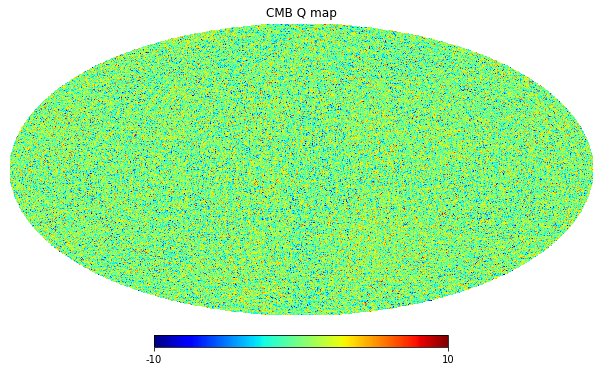

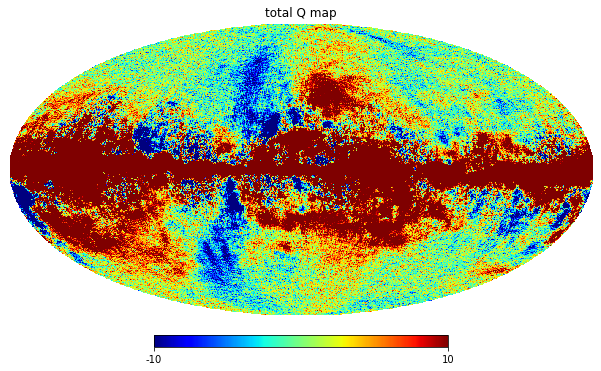

In [20]:
# Plot simulated CMB and total signal full-sky map
cmb = np.load(save_data_dir+'noiseless/cmb/cmb0.npy')
total = np.load(save_data_dir+'noiseless/total/total0.npy')
print(cmb.shape, total.shape)
hp.mollview(cmb[6,0,:], title="CMB Q map",cmap = plt.get_cmap(plt.cm.jet),min=-10,max=10)
hp.mollview(total[6,0,:], title="total Q map",cmap = plt.get_cmap(plt.cm.jet),min=-10,max=10)

fff 431.34293


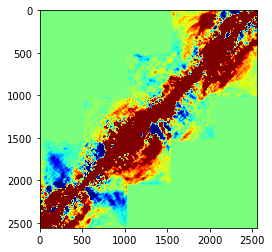

In [42]:
# Transform the spherical full-sky map into a flat map
total = np.load(save_data_dir+'observed_flat_map/training_set/total/total0.npy')
print('fff', np.max(total))
plt.imshow(total[6,0,:], cmap=plt.cm.jet,vmin=-10,vmax=10)

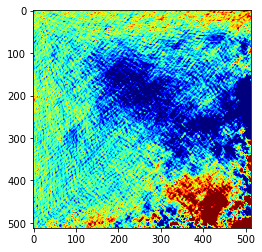

In [40]:
# Select a sky area
total_block = np.load(save_data_dir+'observed_flat_block_map/training_set/total/total0.npy')
plt.imshow(total_block[6,0,:], cmap=plt.cm.jet,vmin=-10,vmax=10)

Training CNN model for Q map:   7%|██████▋                                                                                             | 2/30 [00:02<00:36,  1.30s/it]

Iteration: [3/30] training loss: 2.184964 validation_loss: 2.013957 mean MAD in train set: 1.329640 mean MAD in valid set: 1.233008 



Training CNN model for Q map:  13%|█████████████▎                                                                                      | 4/30 [00:02<00:16,  1.56it/s]

Iteration: [5/30] training loss: 1.620065 validation_loss: 1.570913 mean MAD in train set: 0.982351 mean MAD in valid set: 0.950730 



Training CNN model for Q map:  20%|████████████████████                                                                                | 6/30 [00:03<00:10,  2.33it/s]

Iteration: [7/30] training loss: 1.486836 validation_loss: 1.454632 mean MAD in train set: 0.897431 mean MAD in valid set: 0.876557 



Training CNN model for Q map:  27%|██████████████████████████▋                                                                         | 8/30 [00:03<00:07,  3.04it/s]

Iteration: [9/30] training loss: 1.374316 validation_loss: 1.361568 mean MAD in train set: 0.827348 mean MAD in valid set: 0.819044 



Training CNN model for Q map:  33%|█████████████████████████████████                                                                  | 10/30 [00:04<00:05,  3.67it/s]

Iteration: [11/30] training loss: 1.361413 validation_loss: 1.330544 mean MAD in train set: 0.815860 mean MAD in valid set: 0.802334 



Training CNN model for Q map:  40%|███████████████████████████████████████▌                                                           | 12/30 [00:04<00:04,  4.20it/s]

Iteration: [13/30] training loss: 1.337702 validation_loss: 1.330073 mean MAD in train set: 0.802620 mean MAD in valid set: 0.798242 



Training CNN model for Q map:  47%|██████████████████████████████████████████████▏                                                    | 14/30 [00:04<00:03,  4.61it/s]

Iteration: [15/30] training loss: 1.327377 validation_loss: 1.322343 mean MAD in train set: 0.796653 mean MAD in valid set: 0.793701 



Training CNN model for Q map:  53%|████████████████████████████████████████████████████▊                                              | 16/30 [00:05<00:02,  4.94it/s]

Iteration: [17/30] training loss: 1.321942 validation_loss: 1.317904 mean MAD in train set: 0.793203 mean MAD in valid set: 0.790729 



Training CNN model for Q map:  60%|███████████████████████████████████████████████████████████▍                                       | 18/30 [00:05<00:02,  5.17it/s]

Iteration: [19/30] training loss: 1.294680 validation_loss: 1.292922 mean MAD in train set: 0.779432 mean MAD in valid set: 0.778766 



Training CNN model for Q map:  67%|██████████████████████████████████████████████████████████████████                                 | 20/30 [00:05<00:01,  5.35it/s]

Iteration: [21/30] training loss: 1.293232 validation_loss: 1.291682 mean MAD in train set: 0.778471 mean MAD in valid set: 0.777941 



Training CNN model for Q map:  73%|████████████████████████████████████████████████████████████████████████▌                          | 22/30 [00:06<00:01,  5.48it/s]

Iteration: [23/30] training loss: 1.317944 validation_loss: 1.291147 mean MAD in train set: 0.790587 mean MAD in valid set: 0.777590 



Training CNN model for Q map:  80%|███████████████████████████████████████████████████████████████████████████████▏                   | 24/30 [00:06<00:01,  5.58it/s]

Iteration: [25/30] training loss: 1.324660 validation_loss: 1.290954 mean MAD in train set: 0.792382 mean MAD in valid set: 0.777471 



Training CNN model for Q map:  87%|█████████████████████████████████████████████████████████████████████████████████████▊             | 26/30 [00:06<00:00,  5.62it/s]

Iteration: [27/30] training loss: 1.317545 validation_loss: 1.314702 mean MAD in train set: 0.790352 mean MAD in valid set: 0.788622 



Training CNN model for Q map:  93%|████████████████████████████████████████████████████████████████████████████████████████████▍      | 28/30 [00:07<00:00,  5.70it/s]

Iteration: [29/30] training loss: 1.317472 validation_loss: 1.314634 mean MAD in train set: 0.790306 mean MAD in valid set: 0.788579 


Training CNN model for Q map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Iteration: [31/30] training loss: 1.292198 validation_loss: 1.314605 mean MAD in train set: 0.777808 mean MAD in valid set: 0.788560 


Training CNN model for U map:   7%|██████▋                                                                                             | 2/30 [00:00<00:03,  8.17it/s]

Iteration: [3/30] training loss: 2.006912 validation_loss: 1.769255 mean MAD in train set: 1.218785 mean MAD in valid set: 1.071484 



Training CNN model for U map:  13%|█████████████▎                                                                                      | 4/30 [00:00<00:03,  6.79it/s]

Iteration: [5/30] training loss: 1.425824 validation_loss: 1.410140 mean MAD in train set: 0.859884 mean MAD in valid set: 0.846110 



Training CNN model for U map:  20%|████████████████████                                                                                | 6/30 [00:00<00:03,  6.41it/s]

Iteration: [7/30] training loss: 1.323983 validation_loss: 1.289097 mean MAD in train set: 0.785420 mean MAD in valid set: 0.771508 



Training CNN model for U map:  27%|██████████████████████████▋                                                                         | 8/30 [00:01<00:03,  6.22it/s]

Iteration: [9/30] training loss: 1.256804 validation_loss: 1.218791 mean MAD in train set: 0.740632 mean MAD in valid set: 0.721967 



Training CNN model for U map:  33%|█████████████████████████████████                                                                  | 10/30 [00:01<00:03,  6.09it/s]

Iteration: [11/30] training loss: 1.220844 validation_loss: 1.195949 mean MAD in train set: 0.718834 mean MAD in valid set: 0.704535 



Training CNN model for U map:  40%|███████████████████████████████████████▌                                                           | 12/30 [00:01<00:02,  6.01it/s]

Iteration: [13/30] training loss: 1.175153 validation_loss: 1.182382 mean MAD in train set: 0.693766 mean MAD in valid set: 0.696828 



Training CNN model for U map:  47%|██████████████████████████████████████████████▏                                                    | 14/30 [00:02<00:02,  5.99it/s]

Iteration: [15/30] training loss: 1.182937 validation_loss: 1.175665 mean MAD in train set: 0.696365 mean MAD in valid set: 0.692610 



Training CNN model for U map:  53%|████████████████████████████████████████████████████▊                                              | 16/30 [00:02<00:02,  5.69it/s]

Iteration: [17/30] training loss: 1.197376 validation_loss: 1.172607 mean MAD in train set: 0.704381 mean MAD in valid set: 0.690771 



Training CNN model for U map:  60%|███████████████████████████████████████████████████████████▍                                       | 18/30 [00:02<00:02,  5.71it/s]

Iteration: [19/30] training loss: 1.195310 validation_loss: 1.171327 mean MAD in train set: 0.703315 mean MAD in valid set: 0.690077 



Training CNN model for U map:  67%|██████████████████████████████████████████████████████████████████                                 | 20/30 [00:03<00:01,  5.73it/s]

Iteration: [21/30] training loss: 1.175078 validation_loss: 1.170777 mean MAD in train set: 0.691574 mean MAD in valid set: 0.689803 



Training CNN model for U map:  73%|████████████████████████████████████████████████████████████████████████▌                          | 22/30 [00:03<00:01,  5.75it/s]

Iteration: [23/30] training loss: 1.160220 validation_loss: 1.170509 mean MAD in train set: 0.684465 mean MAD in valid set: 0.689665 



Training CNN model for U map:  80%|███████████████████████████████████████████████████████████████████████████████▏                   | 24/30 [00:04<00:01,  5.77it/s]

Iteration: [25/30] training loss: 1.193644 validation_loss: 1.170368 mean MAD in train set: 0.702485 mean MAD in valid set: 0.689588 



Training CNN model for U map:  87%|█████████████████████████████████████████████████████████████████████████████████████▊             | 26/30 [00:04<00:00,  5.77it/s]

Iteration: [27/30] training loss: 1.174322 validation_loss: 1.170303 mean MAD in train set: 0.691137 mean MAD in valid set: 0.689553 



Training CNN model for U map:  93%|████████████████████████████████████████████████████████████████████████████████████████████▍      | 28/30 [00:04<00:00,  5.78it/s]

Iteration: [29/30] training loss: 1.174271 validation_loss: 1.156279 mean MAD in train set: 0.691106 mean MAD in valid set: 0.681467 


Training CNN model for U map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.74it/s]


Iteration: [31/30] training loss: 1.193457 validation_loss: 1.156268 mean MAD in train set: 0.702386 mean MAD in valid set: 0.681461 


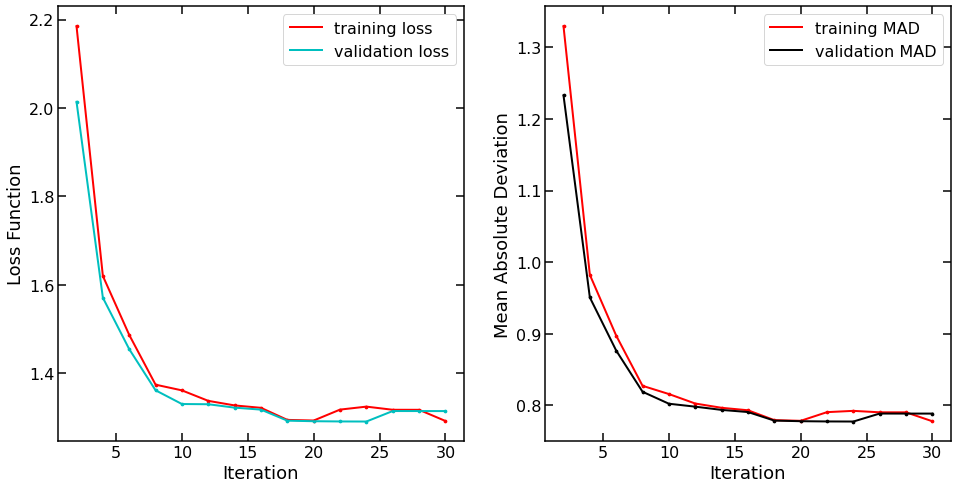

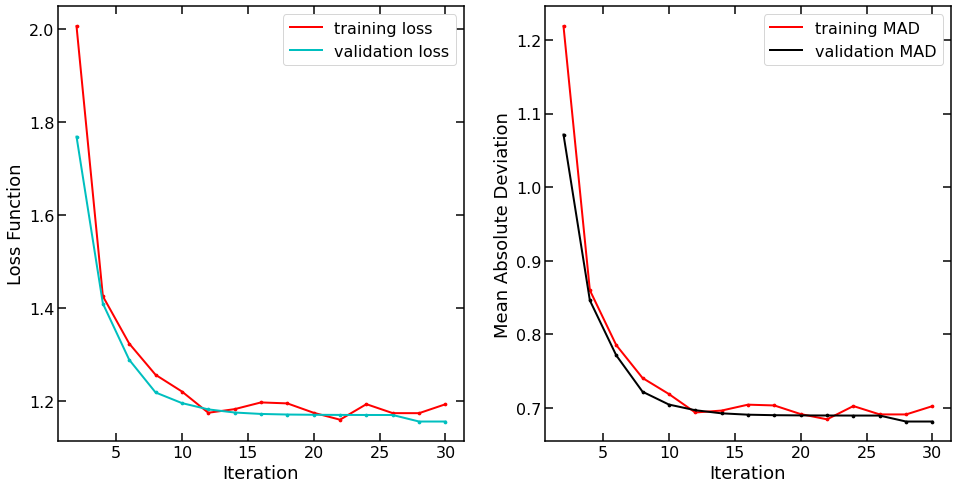

In [12]:
# Training CNN models
cmbfcnn.training_cnn()

In [13]:
# Prediction of CNN models
# get predicted map
cmbfcnn.get_predicted_maps()
# Calculate power spectra
cmbfcnn.calculate_power_spectra()

Calculating power spectra: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.68s/it]


+++++++++++ (2, 2, 306)


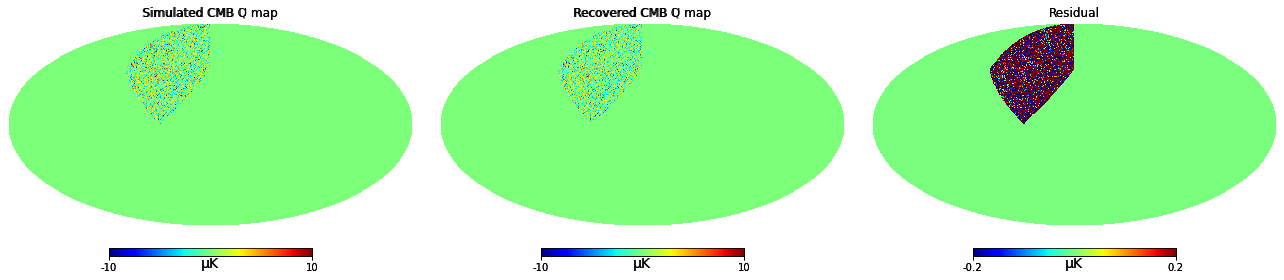

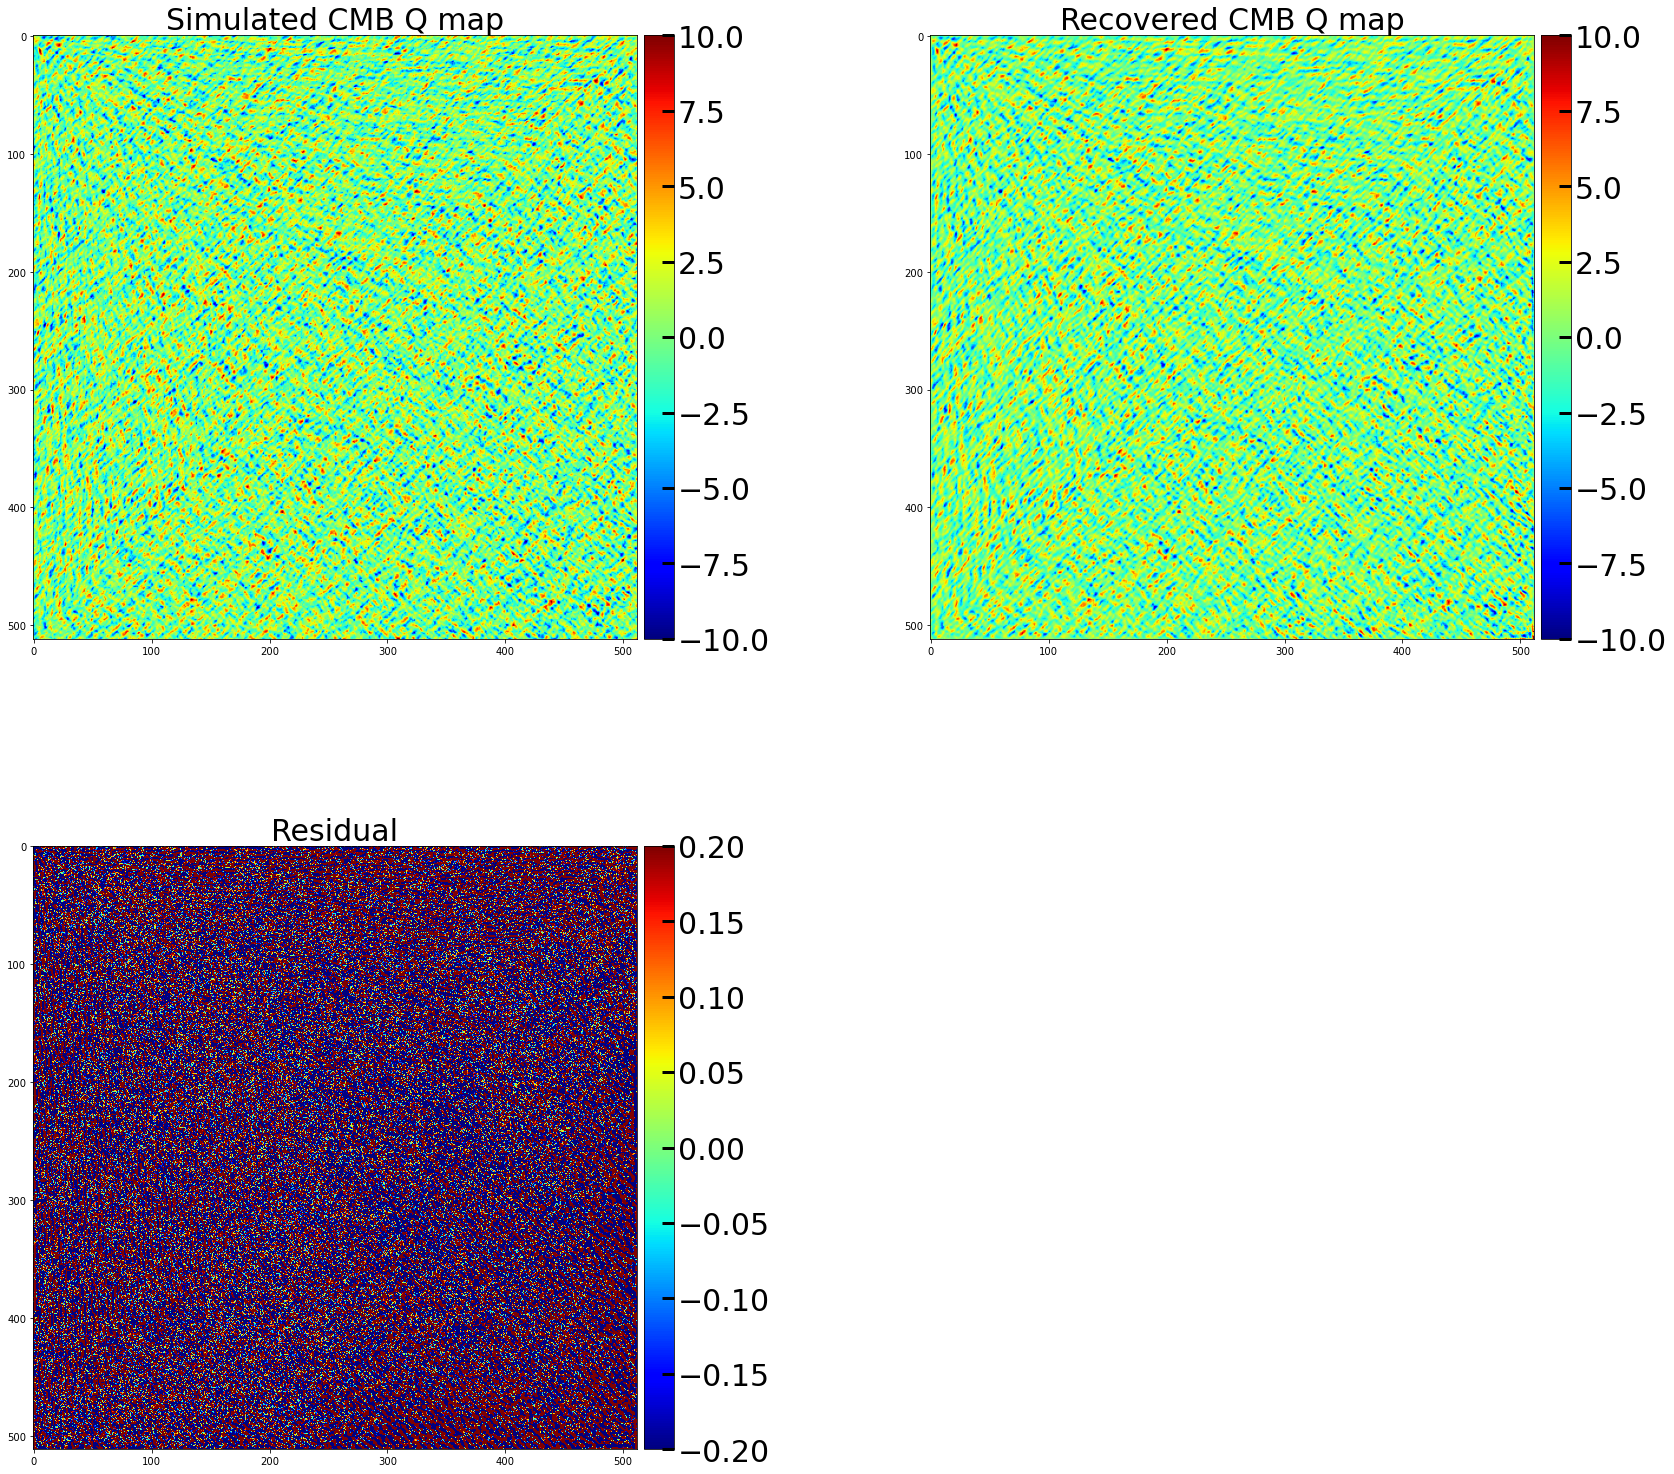

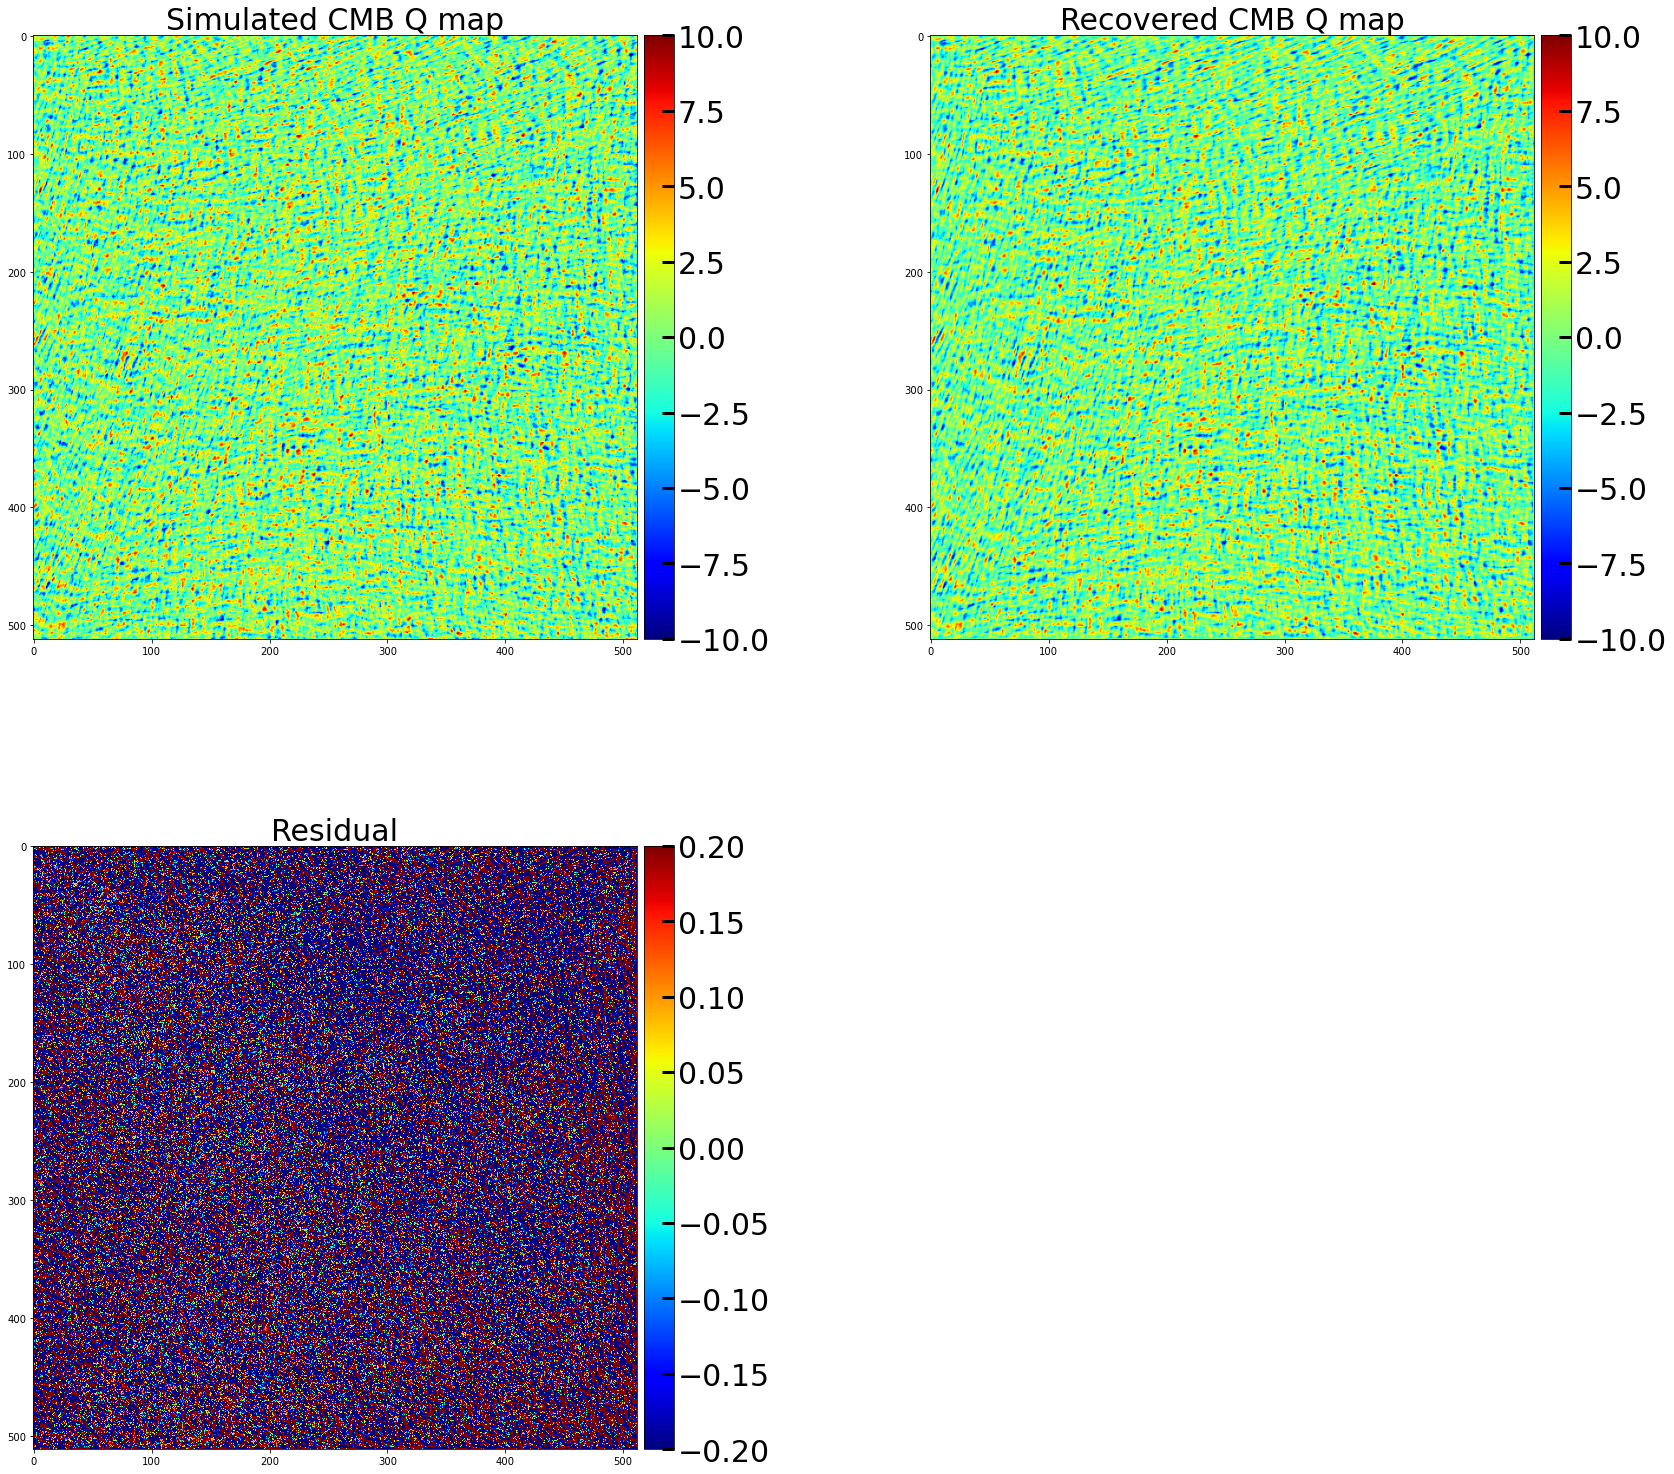

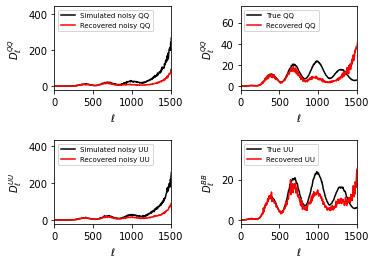

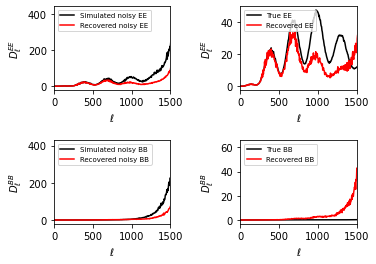

In [14]:
# Plot results
cmbfcnn.Plot_results()